# Flow Fields & Disentanglement

In this notebook, we inspect trained T-FEN models by looking at their learned velocity fields and how the dynamics are split up between the free-form term and the transport term.

In [1]:
from pathlib import Path

import torch
from IPython.display import Image

import finite_element_networks as fen
from finite_element_networks import FENDomainInfo, FENQuery, STBatch
from finite_element_networks.data import Standardizer, InvariantEncoder
from finite_element_networks.plots import animate_disentanglement, animate_flow_fields
from finite_element_networks.utils import load_checkpoint

In [2]:
dataset_name = "scalar-flow"
model_name = "tfen"

project_root = Path(fen.__file__).resolve().parent.parent
ckpt_dir = project_root / "checkpoints"
data_dir = project_root / "data"
dataset_dir = data_dir / dataset_name

We begin by loading the data in a somewhat convoluted, manual way, so that this notebook can also be run without pytorch-lightning.

In [3]:
ckpt = torch.load(ckpt_dir / dataset_name / f"{model_name}.pt")
model = load_checkpoint(ckpt)

stats = np.load(dataset_dir / "stats.npz")
standardizer = Standardizer(stats["mean"], stats["std"])
domain = torch.load(dataset_dir / "domain.pt")["domain"]
u = torch.from_numpy(np.load(dataset_dir / "test" / "sim_000094.npz")["u"])
t = torch.linspace(0.0, 2.0, u.shape[0])

start = 120
steps = 10
batch = STBatch(
    domain,
    FENDomainInfo.from_domain(domain),
    t[start:start+steps][None],
    u[start][None],
    context_steps=1,
    standardizer=standardizer,
    time_encoder=InvariantEncoder(t[0][None])
)
query = FENQuery(
    FENDomainInfo.from_domain(domain),
    t[start:start+steps][None],
    standardizer.do(u[start][None]),
    InvariantEncoder(t[0][None])
)

Now we create a forecast with the model.

In [4]:
with torch.no_grad():
    u_hat = model(query)

## Flow Fields

The following cell renders an animated flow field for the forecast on top of the forecast itself. We see how the flow field clearly captures the movement within the data.

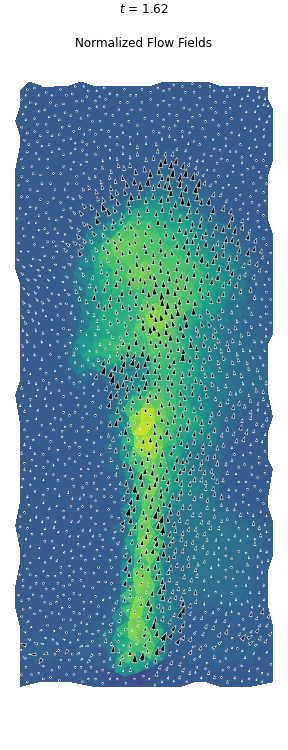

In [5]:
Image(animate_flow_fields(batch, u_hat, model, feature_idx=3))

## Disentanglement

Next, we check to what proportions the time derivative $\partial_t \boldsymbol{y} = f_{\theta} + g_{\theta}$ is created by the free-form and transport term, respectively. The animation shows that the transport term is responsible for most of the variability in the forecast as the data is clearly convection dominated.

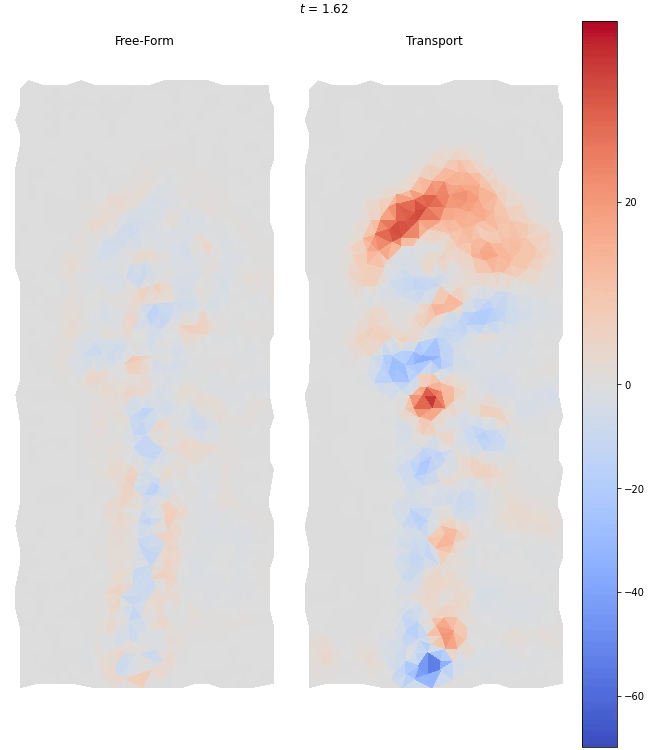

In [6]:
Image(animate_disentanglement(batch, u_hat, model, feature_idx=3))